In [4]:
import os
BRANDON = '/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/'
YASH = '/Users/yashd/Desktop/hierarchical-bayesian-model-validation/'
HANNAH = ''
ZIXUN = ''

ROOT_DIR = YASH
os.chdir(ROOT_DIR + 'testing-framework/')

from utilities import *
from plot_utilities import *

np.random.seed(42)

In [28]:
import scipy.special


def gen_gamma_mean(r, eta):
    return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)

def gen_gamma_variance(r, eta):
    mean = gen_gamma_mean(r, eta)
    second_moment = scipy.special.gamma((eta+3.5)/r) / scipy.special.gamma((eta+1.5)/r)
    return second_moment - mean**2

def kurtosis_prior(r, eta, fisher=True):
    kurtosis = 3*scipy.special.gamma((eta+1.5+2)/r)*scipy.special.gamma((eta+1.5)/r)/scipy.special.gamma((eta+1.5+1)/r)**2
    if fisher:
        return kurtosis - 3
    else:
        return kurtosis 
    
def bootstrap_metric(x, metric=None, n_bootstrap=10000, ci=0.95, replace=True):
    metric_values = []
    sample_size = len(x)
    
    for _ in range(n_bootstrap):
        resampled = np.random.choice(x, size=sample_size, replace=replace)
        metric_values.append(metric(resampled))
    
    metric_point_estimate = metric(x)
    ci_lower = np.percentile(metric_values, (1 - ci) / 2 * 100)
    ci_upper = np.percentile(metric_values, (1 + ci) / 2 * 100)
    
    return metric_point_estimate, ci_lower, ci_upper, metric_values

In [57]:
r, eta = 5, 10
sample = sample_prior(r, eta, 1000000)
var = np.var(sample)
stats.kurtosis(sample), kurtosis_prior(r, eta), np.mean(sample**4)/var**2 - 3

(0.054583765738523304, 0.059515457907479696, 0.05461943855215079)

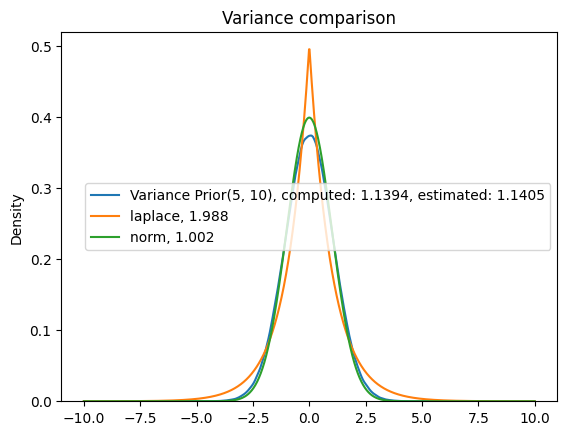

In [58]:
xs = np.linspace(-10, 10, 1000)
ax = plt.subplot()
distnames = ['laplace', 'norm']

sns.kdeplot(sample, label = f'Variance Prior({r}, {eta}), computed: {np.round(var_prior(r, eta), 4)}, estimated: {np.round(np.var(sample), 4)}')
for distname in distnames:
    if distname == 'uniform':
        dist = getattr(stats, distname)(loc=-2, scale=4)
    else:
        dist = getattr(stats, distname)
    data = dist.rvs(size=10000)
    var = np.var(data)
    y = dist.pdf(xs)
    ax.plot(xs, y, label="{}, {}".format(distname, round(var, 3)))
    ax.legend()
plt.title("Variance comparison")
plt.legend(loc='center right')

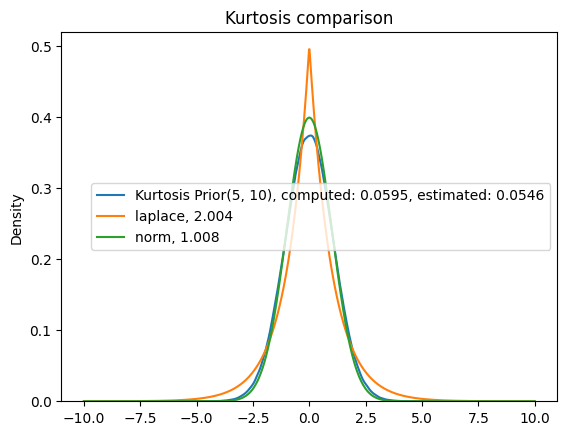

In [59]:
xs = np.linspace(-10, 10, 1000)
ax = plt.subplot()
distnames = ['laplace', 'norm']

sns.kdeplot(sample, label = f'Kurtosis Prior({r}, {eta}), \ncomputed: {np.round(kurtosis_prior(r, eta), 4)}, \nestimated: {np.round(stats.kurtosis(sample), 4)}')
for distname in distnames:
    if distname == 'uniform':
        dist = getattr(stats, distname)(loc=-2, scale=4)
    else:
        dist = getattr(stats, distname)
    data = dist.rvs(size=10000)
    var = np.var(data)
    y = dist.pdf(xs)
    ax.plot(xs, y, label="{}, {}".format(distname, round(var, 3)))
    ax.legend()
plt.title("Kurtosis comparison")
plt.legend(loc='center right')

In [60]:
sample_dict = pd.read_pickle('pickles/sample_data.pickle')
sample_dict
x = sample_dict[2]

In [61]:
kurtosis, ci_lower, ci_upper, all_kurts = bootstrap_kurtosis(x)
print(f"Kurtosis: {kurtosis:.4f}")
print(f"95% Confidence Interval: ({ci_lower:.4f}, {ci_upper:.4f})")

Kurtosis: 0.0736
95% Confidence Interval: (0.0479, 0.0992)


Computed Kurtosis: 0.0595


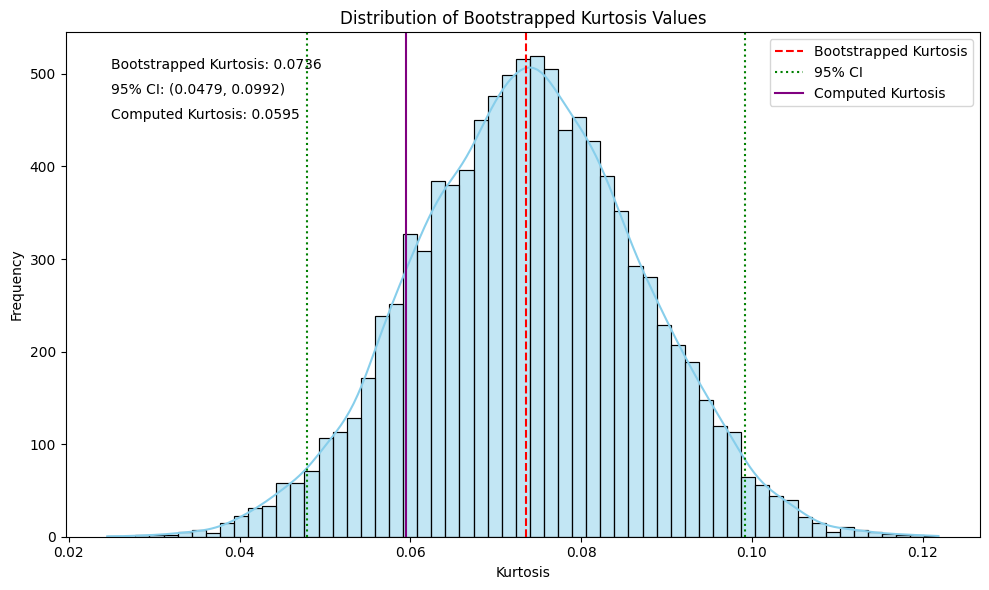

In [63]:
computed_kurtosis = kurtosis_prior(r, eta)
print(f"Computed Kurtosis: {computed_kurtosis:.4f}")

plt.figure(figsize=(10, 6))
sns.histplot(all_kurts, kde=True, color='skyblue')
plt.axvline(kurtosis, color='red', linestyle='--', label='Bootstrapped Kurtosis')
plt.axvline(ci_lower, color='green', linestyle=':', label='95% CI')
plt.axvline(ci_upper, color='green', linestyle=':')
plt.axvline(computed_kurtosis, color='purple', linestyle='-', label='Computed Kurtosis')

plt.title('Distribution of Bootstrapped Kurtosis Values')
plt.xlabel('Kurtosis')
plt.ylabel('Frequency')
plt.legend()

plt.text(0.05, 0.95, f'Bootstrapped Kurtosis: {kurtosis:.4f}', transform=plt.gca().transAxes, verticalalignment='top')
plt.text(0.05, 0.90, f'95% CI: ({ci_lower:.4f}, {ci_upper:.4f})', transform=plt.gca().transAxes, verticalalignment='top')
plt.text(0.05, 0.85, f'Computed Kurtosis: {computed_kurtosis:.4f}', transform=plt.gca().transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()